In [1]:
import tskit
import msprime
import stdpopsim
import networkx as nx
import matplotlib.pyplot as plt
import io
from IPython.display import display as SVG
import sys
import tszip
import pandas as pd
import numpy as np

C:\Users\Philip\miniconda3\envs\Masterarbeit\Lib\site-packages\stdpopsim\catalog\HomSap\demographic_models.py:158: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  time=int(extended_GF.time.head(1) - 1), rate=0
C:\Users\Philip\miniconda3\envs\Masterarbeit\Lib\site-packages\stdpopsim\catalog\HomSap\demographic_models.py:161: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  time=int(extended_GF.time.tail(1) + 1), rate=0


In [10]:
#visualize pedigrees
def draw_pedigree(ped_ts):
    G = nx.DiGraph()
    for ind in ped_ts.individuals():
        time = ped_ts.node(ind.nodes[0]).time
        pop = ped_ts.node(ind.nodes[0]).population
        G.add_node(ind.id, time=time, population=pop)
        for p in ind.parents:
            if p != tskit.NULL:
                G.add_edge(ind.id, p)
    pos = nx.multipartite_layout(G, subset_key="time", align="horizontal")
    colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
    node_colours = [colours[node_attr["population"]] for node_attr in G.nodes.values()]
    nx.draw_networkx(G, pos, with_labels=True, node_color=node_colours)
    plt.show()

In [81]:
pb = msprime.PedigreeBuilder(
    individuals_metadata_schema=tskit.MetadataSchema.permissive_json())
mom_id = pb.add_individual(time=1, metadata={"name": "mom"})
dad_id = pb.add_individual(time=1, metadata={"name": "dad"})
pb.add_individual(
    time=0, parents=[mom_id, dad_id], is_sample=True, metadata={"name": "child"})
pedigree = pb.finalise()
display(pedigree.nodes)

id,flags,population,individual,time,metadata
0,0,0,0,1,
1,0,0,0,1,
2,0,0,1,1,
3,0,0,1,1,
4,1,0,2,0,
5,1,0,2,0,


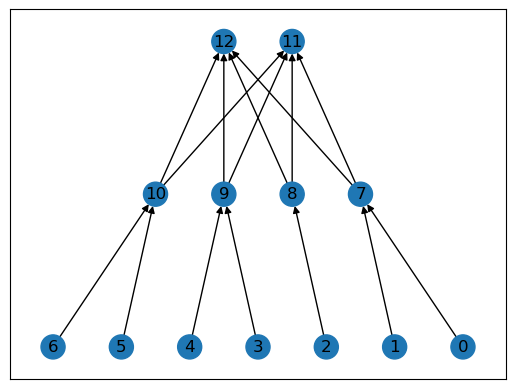

In [11]:
#example pedigrees
#id doesnt matter except for parent child relationships
ped_txt = """\
# id parent0 parent1 time
0 7 7 0.0
1 7 7 0.0
2 8 8 0.0
3 9 9 0.0
4 9 9 0.0
5 10 10 0.0
6 10 10 0.0
7 11 12 1.0
8 11 12 1.0
9 11 12 1.0
10 11 12 1.0
11 . . 2.0
12 . . 2.0
"""

pedigree = msprime.parse_pedigree(io.StringIO(ped_txt), sequence_length = 100)

draw_pedigree(pedigree.tree_sequence())

In [94]:
ped_txt

'# id parent0 parent1 time\n0 7 7 0.0\n1 7 7 0.0\n2 8 8 0.0\n3 9 9 0.0\n4 9 9 0.0\n5 10 10 0.0\n6 10 10 0.0\n7 11 12 1.0\n8 11 12 1.0\n9 11 12 1.0\n10 11 12 1.0\n11 . . 2.0\n12 . . 2.0\n'

In [84]:
df = pd.DataFrame(
{"id":[0, 1, 2],
"parent0" : [1, ".", "."],
"parent1" : [1, ".", "."],
"time" : [0.0, 1.0, 1.0]},
index = [0, 1, 2])


In [85]:
df

,id,parent0,parent1,time
0,0,1,1,0.0
1,1,.,.,1.0
2,2,.,.,1.0


In [92]:
print("#" + df.to_string(index = False))

# id parent0 parent1  time
  0       1       1   0.0
  1       .       .   1.0
  2       .       .   1.0


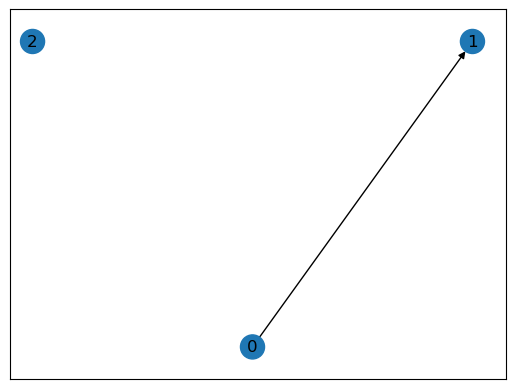

In [99]:
pedigree = msprime.parse_pedigree(io.StringIO("#" + df.to_string(index = False)), sequence_length = 100)

draw_pedigree(pedigree.tree_sequence())

In [70]:
df = pd.read_table(io.StringIO(df.to_string()))

In [71]:
print(df.to_string())

         a  b   c
0  test          
1  1     4  7  10
2  2     5  8  11
3  3     6  9  12


In [ ]:
#define functions for building pedigrees for breeding

#transform text to pd df

#transform pd df to text

#generate pedigree text
def pedigree_init():
    
    

#combine n choose 2 (assuming two different parents) or list of crosses. out: n choose 2 pb classes

#selfing (adding selfed individual to pedigree)

#breeding schemes

In [ ]:
#generate pedigrees for breeding scheme

#bulk selection

#single seed descent

#...